In [1]:
import random
import black, pygame, green

# this is the apple object of the snake game
class Apple:
    
    def __init__(self, gameDisplay, display_width, display_height, block_size, img, snake_list, apple_thickness = 1):
        self.gameDisplay = gameDisplay
        self.display_width = display_width
        self.display_height = display_height
        self.block_size = block_size
        self.apple = img
        self.apple_thickness = apple_thickness
        
        self.rand_apple_x = random.randint(0, self.display_width/self.block_size - 1) * 1#10 
        self.rand_apple_y = random.randint(0, self.display_height/self.block_size - 1) * 1#10 

        while [self.rand_apple_x, self.rand_apple_y] in snake_list:
            self.rand_apple_x = random.randint(0, self.display_width/self.block_size - 1) * 1#10 
            self.rand_apple_y = random.randint(0, self.display_height/self.block_size - 1) * 1#10

    # method to get the new apple
    def update_apple_pos(self, snake_list):
        self.rand_apple_x = random.randint(0, self.display_width/self.block_size - 1) * 1#10 
        self.rand_apple_y = random.randint(0, self.display_height/self.block_size - 1) * 1#10 

        while [self.rand_apple_x, self.rand_apple_y] in snake_list:
            self.rand_apple_x = random.randint(0, self.display_width/self.block_size - 1) * 1#10 
            self.rand_apple_y = random.randint(0, self.display_height/self.block_size - 1) * 1#10

    # get the apple 
    def get_apple_pos(self):
        return self.rand_apple_x, self.rand_apple_y

    # display the apple to the pygame board
    def display(self):        
        self.gameDisplay.blit(self.apple, [self.rand_apple_x, self.rand_apple_y, self.apple_thickness,
                                 self.apple_thickness])


# this is the snake object of the snake game
class Snake:
    def __init__(self, gameDisplay, display_width, display_height, img, x, y, block_size =1):
        self.gameDisplay = gameDisplay
        self.display_width = display_width
        self.display_height = display_height
        self.head = img
        self.snake_length = 1
        self.snake_list = [[x, y]]
        self.block_size = block_size
        self.eaten = False
        self.direction = "right"

    # check if the snake is still alive
    def is_alive(self):
        if self.snake_list[-1][0] >= self.display_width or self.snake_list[-1][0] < 0 or self.snake_list[-1][1] >= self.display_height\
                or self.snake_list[-1][1] < 0:
            return False
        elif self.snake_list[-1] in self.snake_list[:-1]:
            return False
        else:
            return True

    # check if snake eats the apple
    def eat_apple(self, rand_apple_x, rand_apple_y):
        if self.snake_list[-1][0] == rand_apple_x and self.snake_list[-1][1] == rand_apple_y:
            return True
        else: 
            return False
    
    # display the score to the pygame board 
    def display_score(self):
        score = self.snake_length - 1
        text = pygame.font.SysFont("Comic Sans MS", 15).render("Score: " + str(score), True, black)
        self.gameDisplay.blit(text, [0, 0])

    # return the snake head position
    def get_snake_head(self):
        return self.snake_list[-1][0], self.snake_list[-1][1]

    # move the snake by one step based on the snake's direction
    def update_snake_list(self, rand_apple_x, rand_apple_y):
        if self.direction == "left":
            lead_x_change = -self.block_size
            lead_y_change = 0
        elif self.direction == "right":
            lead_x_change = self.block_size
            lead_y_change = 0
        elif self.direction == "up":
            lead_y_change = -self.block_size
            lead_x_change = 0
        elif self.direction == "down":
            lead_y_change = self.block_size
            lead_x_change = 0

        snake_head = []
        snake_head.append(self.snake_list[-1][0] + lead_x_change)
        snake_head.append(self.snake_list[-1][1] + lead_y_change)
        self.snake_list.append(snake_head)

        if self.eat_apple(rand_apple_x, rand_apple_y):
            self.snake_length += 1
            self.eaten = True

        if len(self.snake_list) > self.snake_length:
            del self.snake_list[0]

    # display the snake to the board
    def display(self):
        self.gameDisplay.blit(self.head, (self.snake_list[-1][0], self.snake_list[-1][1]))

        for XnY in self.snake_list[:-1]:
            pygame.draw.rect(self.gameDisplay, green,
                            [XnY[0], XnY[1], self.block_size, self.block_size])

# extend the snake to facilitate the RL
class RL_Snake(Snake):
    # this one will return the state of the snake
    # the state is: with the direction snake is in
    # (what is in the left cell, what is in the above cell, what is in the right cell
    # , (diff of the position between target and the snake head))
    def get_state(self, target):            
        head_x, head_y = self.get_snake_head()
        start = [head_x, head_y]

        if self.direction == "up":
            options = [[start[0] - self.block_size, start[1]], [start[0], start[1] - self.block_size], [start[0] + self.block_size, start[1]]]
        elif self.direction == "right":
            options = [[start[0], start[1] - self.block_size], [start[0] + self.block_size, start[1]], [start[0], start[1] + self.block_size]]
        elif self.direction == "down":
            options = [[start[0] + self.block_size, start[1]], [start[0], start[1] + self.block_size], [start[0] - self.block_size, start[1]]]
        elif self.direction == "left":
            options = [[start[0], start[1] + self.block_size], [start[0] - self.block_size, start[1]], [start[0], start[1] - self.block_size]]

        state = []

        for o in options:
            result = None
            if [o[0], o[1]] in self.snake_list or o[0] < 0 or o[0] >= self.display_width or o[1] <0 or o[1] >= self.display_height:
                result = 1
            elif o == target:
                result = 2
            else:
                result = 0
            state.append(result)

        # until now, we will get what is in the left, up, right side of the snake head
        # 1 is something will get the snake die
        # 2 is the apple
        # 0 is empty space

        # quadrant is the difference of the position between target and snake head
        #quadrant = [target[0] - start[0], target[1] - start[1]]
        quadrant = [start[0] - target[0], start[1] - target[1]]

        if self.direction == "up":
            pass
        elif self.direction == "right":
            temp = quadrant[0]
            quadrant[0] = quadrant[1]
            quadrant[1] = -temp
        elif self.direction == "down":
            temp = quadrant[0]
            quadrant[0] = -quadrant[1]
            quadrant[1] = -temp
        elif self.direction == "left":
            temp = quadrant[0]
            quadrant[0] = -quadrant[1]
            quadrant[1] = temp
        state.append(tuple(quadrant))

        return state

    # method change the direction based on the action chosen
    def set_direction_by_action(self, action):
        look_up = {"up": 0, "right": 1, "left": -1}   
        value = look_up[action]

        if self.direction == "up":
            if value != 0:
                self.direction = ("left" if value == -1 else "right")
            else:
                self.direction = "up"
        elif self.direction == "right":
            if value != 0:
                self.direction = ("up" if value == -1 else "down")
            else:
                self.direction = "right"
        elif self.direction == "down":
            if value != 0:
                self.direction = ("right" if value == -1 else "left")
            else:
                self.direction = "down"
        elif self.direction == "left":
            if value != 0:
                self.direction = ("down" if value == -1 else "up")
            else:
                self.direction = "left"

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
import random
import numpy as np
import pickle


# RL object
class Sarsa_RL():
    def __init__(self, actions, e = 0.01, a = 0.1, g = 0.95):
        self.Q = {}
        self.value_function = self.create_value_function()
        #self.states_count = self.create_states_count()
        self.A = actions
        self.e = e
        self.a = a
        self.g = g

    # method to return the Q based on (state, action)
    def getQ(self, state, action):
        # default 0
        return self.Q.get((state, action), 0.0)
    
    # set the Q
    def setQ(self, Q):
        self.Q = Q

    # load the Q from the txt
    def loadQ(self):
        self.Q =  pickle.load(open("Q.txt", "rb"))
    
    # save Q to the txt 
    def saveQ(self):
        f = open("Q.txt", "wb")
        pickle.dump(self.Q, f)
        f.close()
    
    # get the action based on the state
    def getA(self, state):
        if random.random() < self.e:
            result = random.choice(self.A)
        else:
            q_list = [self.getQ(state, a) for a in self.A]
            max_q = max(q_list)
            index = np.where(np.array(q_list) == max_q)
            result = self.A[random.choice(index[0])]
        return result
    
    def create_value_function(self):
        global display_height
        global display_width
        value = {}

        for x in range(-display_width+1, display_width):
            for y in range(-display_height+1, display_height):

                value[f'({x}, {y})'] = 0

        #value[str((0,0))] = np.inf #pois esse é estado final e o que mais vale
        return value

    # method to update Q for (state, action)
    # this is the only difference between Qlearning and SARSA
    # Sarsa is updating by using the same action chosen by the getQ method
    #def updateQ(self, state, action, new_state, new_action, reward):
    #    q = self.Q.get((state, action), None)
    #    if q is None:
    #        self.Q[(state, action)] = reward
    #    else:
    #        if not new_state:
    #            self.Q[(state, action)] = q + self.a*(reward-q)
    #        else:
    #            new_q = self.getQ(new_state, new_action)
    #            self.Q[(state, action)] = q + self.a * (reward + self.g * new_q - q)
    def updateQ(self, state, action, new_state, new_action, reward):
        q = self.Q.get((state, action), None)
        if q is None:
            self.Q[(state, action)] = reward
        else:
            new_q = self.getQ(new_state, new_action)
            self.Q[(state, action)] = q + self.a * (reward + self.g * new_q - q)
            self.value_function[str(state[3])] = q + self.a * (reward + self.g * new_q - q)

In [29]:
import pygame
import random
#from ReinforcementLearning import QLearing
#from models import Apple, RL_Snake

pygame.init()

# colors
white = (0, 0, 0)
black = (255, 255, 255)
red = (255, 0, 0)
green = (0, 155, 0)

# window size
display_width = 10#150
display_height = 10#150

# all the pygame settings
gameDisplay = pygame.display.set_mode((display_width, display_height))
pygame.display.set_caption("Snake Game")
clock = pygame.time.Clock()
icon = pygame.image.load("apple.png")
pygame.display.set_icon(icon)
img = pygame.image.load('snakehead.png')
img2 = pygame.image.load('apple.png')
pygame.display.flip()


block_size = 1
# frame per second will control the game speed
FPS = 20

# set up for Sarsa
actions = ["up", "left", "right"]
snake_agent = Sarsa_RL(actions, e = 0.01)
Sarsa_True = True

# if it is the first time to train, there is no Q.txt to load
# then comment out this line
#snake_agent.loadQ()

# training method
def training_game(times = 1):
    # s list will store the score of each game
    s = []

    episode_states = []
    episode_rewards = 0
    for i in range(times):
        # print out the game number
        #print(i)

        pygame.event.pump()
        game_over = False

        # snake will start in the middle of the game window
        lead_x = 5#70
        lead_y = 5#70

        # snake default direction is right
        snake = RL_Snake(gameDisplay, display_width, display_height, img, lead_x, lead_y)
        apple = Apple(gameDisplay, display_width, display_height, block_size, img2, snake.snake_list)

        a_x, a_y = apple.get_apple_pos()
        
        # get the initial state, and action will be "up" starting
        old_state = snake.get_state([a_x, a_y])
        old_action = "up"

        while not game_over:
                   
            # based on the direction, we can work out the x, y changes to update the snake
            a_x, a_y = apple.get_apple_pos()
            snake.update_snake_list(a_x, a_y)

            # snake not die or eats the apple, reward will be -10
            # this is negative so that it will "encourage" the snake to 
            # move towards to the apple, since that is the only positive award
            reward = -1#-10
            #episode_rewards += g**(len(episode_states)) * reward
            #steps_c += 1
            
            # check if snake dies
            if snake.is_alive() is False:
                game_over = True
                # if snake dies, award is -100
                reward = -10#-100
                #episode_rewards += g**(len(episode_states)) * reward
                s.append(snake.snake_length-1)

            gameDisplay.fill(white)
            
            # if snake eats the apple, make a random new apple
            if snake.eaten is True:
                apple.update_apple_pos(snake.snake_list)
                # if snake eats the apple, reward is 500
                reward = 99#500
                #episode_rewards += g**(len(episode_states)) * reward
            
            # get he new state and new action, then we can update the Q table
            state = snake.get_state([a_x, a_y])
            action = snake_agent.getA(tuple(state))
            episode_states.append(state[3])
            snake_agent.updateQ(tuple(old_state), old_action, tuple(state), action, reward)
            old_action = action
            #print(episode_states[0])
            #v = snake_agent.value_function[str(episode_states[0])]
            #print(v)
            #snake_agent.value_function[str(state[3])] = v + alpha*(episode_rewards - v)
            #print(snake_agent.value_function[str(episode_states[0])])
            #print(state[3])

            # training will take a lot of time, so archive the Q table
            snake_agent.saveQ()

            # this part is using the snake position and apple
            # position to use the Sarsa method to get the action
            a_x, a_y = apple.get_apple_pos()
            old_state = snake.get_state([a_x, a_y])
            snake.set_direction_by_action(action)

            apple.display()
            snake.eaten = False
            snake.display()
            snake.display_score()
            pygame.display.update()
            clock.tick(FPS)

        #steps_list.append(steps_c)
        #v = value_function[str(episode_states[0])]
        #value_function[str(episode_states[0])] = v + alpha*(episode_rewards - v)
    # after traning is done, print out the average score
    print("Average score is: {}".format(sum(s)/len(s)))
    #print("Average reward was: ", r/len(s))
    #print("Average steps are: ", sum(steps_list)/len(steps_list))
    #print(s)
    #print(episode_states)
    #print(episode_rewards)

if __name__ == "__main__":
    training_game()

Average score is: 0.0


In [ ]:
# first run:
# Average score is: 0.52
#Total reward was:  -24740

# second run:
# Average score is: 1.17
# Total reward was:  12060

#time took:  ~200s

# vou reduzir pra 10 jogos por episódio pq tá demorando muito

# third run:
# Average score is: 1.1
# Total reward was:  1170

# time took: 17s

In [34]:
pygame.quit()

In [32]:
for n in range(0, 10000):
  print(n)
  training_game()

with open(f'value_function_{n}runs.pkl', 'wb') as fp:
  pickle.dump(snake_agent.value_function, fp)

with open(f'q_{n}runs.pkl', 'wb') as fp:
  pickle.dump(snake_agent.Q, fp)

0
Average score is: 3.0
1
Average score is: 3.0
2
Average score is: 3.0
3
Average score is: 1.0
4
Average score is: 4.0
5
Average score is: 1.0
6
Average score is: 3.0
7
Average score is: 7.0
8
Average score is: 4.0
9
Average score is: 1.0
10
Average score is: 1.0
11
Average score is: 2.0
12
Average score is: 2.0
13
Average score is: 7.0
14
Average score is: 4.0
15
Average score is: 2.0
16
Average score is: 3.0
17
Average score is: 1.0
18
Average score is: 1.0
19
Average score is: 4.0
20
Average score is: 6.0
21
Average score is: 2.0
22
Average score is: 2.0
23
Average score is: 10.0
24
Average score is: 3.0
25
Average score is: 3.0
26
Average score is: 5.0
27
Average score is: 5.0
28
Average score is: 7.0
29
Average score is: 1.0
30
Average score is: 1.0
31
Average score is: 3.0
32
Average score is: 1.0
33
Average score is: 8.0
34
Average score is: 9.0
35
Average score is: 2.0
36
Average score is: 2.0
37
Average score is: 1.0
38
Average score is: 4.0
39
Average score is: 1.0
40
Averag

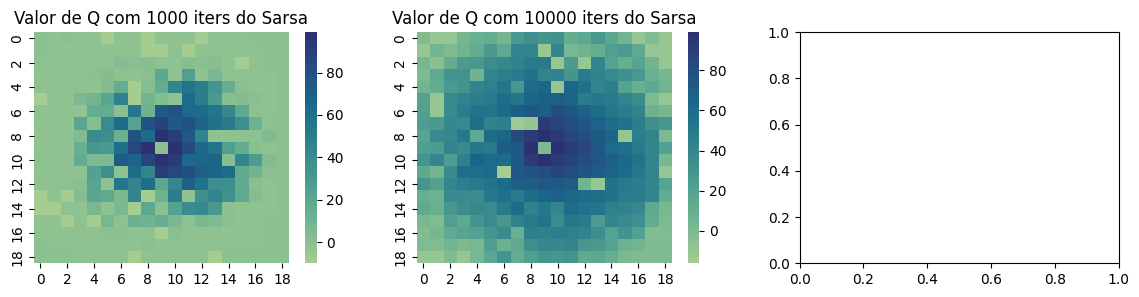

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
for i, n in enumerate([999, 9999]):
  with open(f'value_function_{n}runs.pkl', 'rb') as fp:
    value_function = pickle.load(fp)

  matrix_values = np.zeros((19, 19))
  #print(value_function.keys())
  for k in list(value_function.keys()):
    #print(k)
    x = int(k.split(',')[0].split('(')[1])
    y = int(k.split(',')[1].split(')')[0])

    matrix_values[x+9][y+9] = value_function[k]

  #matrix_values[19][19] = 0

  sns.heatmap(matrix_values, ax = axs[i], cmap="crest")#, annot = True)
  axs[i].set_title(f'Valor de Q com {n+1} iters do Sarsa')

In [51]:
value_function

{'(-9, -9)': 0,
 '(-9, -8)': 0,
 '(-9, -7)': 0,
 '(-9, -6)': 0,
 '(-9, -5)': 0,
 '(-9, -4)': 0,
 '(-9, -3)': 0,
 '(-9, -2)': 0,
 '(-9, -1)': 0,
 '(-9, 0)': 0,
 '(-9, 1)': 0,
 '(-9, 2)': 0,
 '(-9, 3)': 0,
 '(-9, 4)': 0,
 '(-9, 5)': 0,
 '(-9, 6)': 0,
 '(-9, 7)': 0,
 '(-9, 8)': 0,
 '(-9, 9)': 0,
 '(-8, -9)': 0,
 '(-8, -8)': 0,
 '(-8, -7)': 0,
 '(-8, -6)': 0,
 '(-8, -5)': 0,
 '(-8, -4)': 0,
 '(-8, -3)': 0,
 '(-8, -2)': 0,
 '(-8, -1)': 0,
 '(-8, 0)': 0,
 '(-8, 1)': 0,
 '(-8, 2)': 0,
 '(-8, 3)': 0,
 '(-8, 4)': 0,
 '(-8, 5)': 0,
 '(-8, 6)': 0,
 '(-8, 7)': 0,
 '(-8, 8)': 0,
 '(-8, 9)': 0,
 '(-7, -9)': 0,
 '(-7, -8)': 0,
 '(-7, -7)': 0,
 '(-7, -6)': 0,
 '(-7, -5)': 0,
 '(-7, -4)': 0,
 '(-7, -3)': 0,
 '(-7, -2)': 0,
 '(-7, -1)': 0,
 '(-7, 0)': 0,
 '(-7, 1)': 0,
 '(-7, 2)': 0,
 '(-7, 3)': 0,
 '(-7, 4)': 0,
 '(-7, 5)': 0,
 '(-7, 6)': 0,
 '(-7, 7)': 0,
 '(-7, 8)': 0,
 '(-7, 9)': 0,
 '(-6, -9)': 0,
 '(-6, -8)': 0,
 '(-6, -7)': 0,
 '(-6, -6)': 0,
 '(-6, -5)': 0,
 '(-6, -4)': 0,
 '(-6, -3)': 0,
 '(-6,